# Segmentation with bias correction and morphology

*Author: Anders Bjorholm Dahl (abda@dtu.dk)*

This explains how to correct for bias and segment a slice from a CT scanned chalk sample. 

**Authors:** Anders Bjorholm Dahl (abda@dtu.dk) and Vedrana Andersen Dahl (vand@dtu.dk)

The outline of the exercise is:

1 Introduction

1.1 Read and investigate the image

2 Noise reomoval

3 Correct for bias

4 Threshold

5 Morhpology

6 Visualisation


## Introduction

The aim of this exercise is to separate the image into regions of the same material. In the given example we have a scanned chalk sample containing voids of air. We are interested in mapping out these regions, because the air and its topology determines the permeability of the sample, and the regions containing chalk determines the mechanical properties of the sample. Therefore, our aims is to separate the sample into regions of chalk and air.

We will now described the segmentation problem mathematically. We have a volumetric image $I(\mathbf{x})$ where $\mathbf{x} \in \Omega \subset \mathbb{R}^3$. Here $\Omega$ is the image domain and $\mathbf{x} = \{x,y,z\}$ is a position in the image. We refer to each element of $I$ as a pixel. Our aim is to partition $I$ into a segmentation $S$ where $S(\mathbf{x}) = k$. $k$ is the label and $k = \{1, \dots, K\}$. In the specific problem we have $K = 2$ where $k = 1$ for air and $k = 2$ for chalk. 

$S$ is defined on the image domain $\Omega$ and therefore $S$ can have sub-pixel accuracy, but to simplify the problem we will model the segmentation as a pixel classification problem. Therefore, we need some classification function $\mathcal{C}(I(\mathbf{x})) = S(\mathbf{x})$ that assigns a label to each pixel in the image. An often used and very simple classification function is a threshold, where 

\begin{equation}
\mathcal{C}(I(\mathbf{x})) = \left\{
\begin{array}{ccc}
1 & \textrm{if} & I(\mathbf{x}) < \tau \\
2 & \textrm{else} & 
\end{array} \right. \ .
\end{equation}
$\tau$ is the threshold value. This will map the image to two classes by running through all pixels in the image and determining if the pixel intensity is below the value $\tau$. 

Since the image is a tomographic reconstruction of chalk and air, and chalk has a higher density than air, we would expect that a suitable threshold value would separate the pixels correctly. However, in this case both reconstruction artefacts and noise in the image lead to errors in a threshold-based segmentation, which is often the case when working with tomographic data. A common cause for artefacts is that the tomographic reconstruction model deviates from the physical properties of the scanning pipeline because there are factors that are not accounted for. Another cause is that the model solution is non-unique if e.g. few projections are recorded. 

You will work with an image from a volume of scanned chalk, where the internal part is the region of interest $I_\textrm{roi}$. In the image we see ring artefacts, which is typically caused by errors in the image detector. Also beam hardening is clearly seen here, which is caused by a change in the spectral composition of the X-rays, and this change is not accounted for in the reconstruction. Furthermore, the imaging process is photon detection, which is stochastic, and coupled with the reconstruction this will often lead to high frequency noise. So, to get a suitable segmentation we will model the beam hardening and noise. In this data, the ring artefacts does not influence the segmentation much, so we have chosen to ignore them. 

We will model the image as
\begin{equation}
I(\mathbf{x}) = \hat{B}(\mathbf{x}) \hat{I}(\mathbf{x}) + \epsilon
\end{equation}
where $\hat{B}$ is the bias term, $\hat{I}$ is the image that we aim at recovering, and $\epsilon$ is the noise term. Our approach is first to remove the noise by filtering the image, and then we will compute the bias term.



##Load libraries

In [ ]:
# Run this code to include the nessecary packages

import cv2 as cv
import skimage.io as skio
import skimage.filters as skfi
import skimage.morphology as skmo
import skimage.measure as skme

import scipy.ndimage as snd


# functionality for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mp

import numpy as np

import urllib.request
import PIL

## 1.1 Read and investigate the image

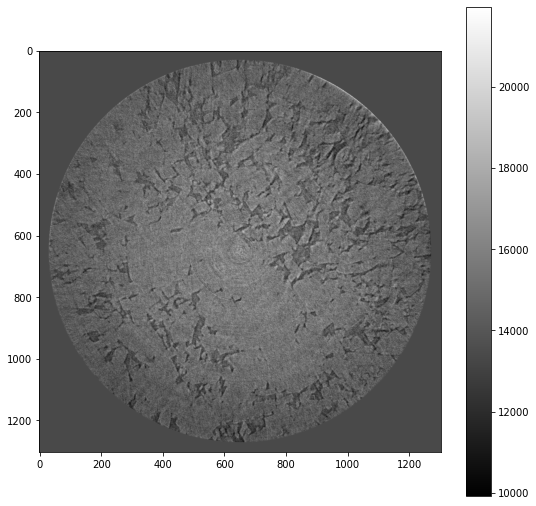

In [ ]:
# Read the image
url = 'https://qim.compute.dtu.dk/data-repository/demo_data/rh0001.tif'
im_org = np.array(PIL.Image.open(urllib.request.urlopen(url))).astype(np.int32)

# Display image
fig = plt.figure(figsize=(9,9))
plt.imshow(im_org, cmap='gray')
plt.colorbar()
fig.show()

### See histogram
The pixelwise distribution can be seen from the histogram

In [ ]:
fig = plt.figure(figsize=(12,5))
plt.hist(im_org.ravel(), 300, color = 'k')
plt.show()

### Threshold image
A threshold of the image can show some of the image features and give an idea of the difficulty in obtaining a segmentation.

In [ ]:
# Threshold image
thres_val = 14000
thres = ( im_org > thres_val )

fig = plt.figure(figsize=(10,10))
plt.imshow(thres, cmap="gray")
fig.show()

### Region of interest
It is important to carry out the analysis in the region of interest, $I_\textrm{roi}$, and we compute this by finding an image based on the connected component outside $I_\textrm{roi}$ and then transforming this to $I_\textrm{roi}$.

In [ ]:
# Value outside the region of interest
r_val = im_org[0,0]

# Find image equal to value outside region of interest
r_im = (im_org == r_val).astype(np.uint8)

# You need to choose 4 or 8 for connectivity type
connectivity = 4

# Perform connected component analysis
labels = skmo.label(r_im,background=0)


# Get the results

# The labels have the value 1 in the outer part

# Choose the opposite part
im_roi_outside = (labels==1).astype(np.uint8)
im_roi = 1-im_roi_outside

rp = skme.regionprops(im_roi)
center = rp[0].centroid

# Show region of interest image
fig = plt.figure(figsize=(8,8))
plt.imshow(im_roi, interpolation="nearest", cmap="jet")
fig.show()

## 2 Noise removal
Tomographic images are often relatively smooth, which means that intensities changes only little between neighbouring pixels except on boundaries between different materials. In contrast, image noise often appears as abrupt local changes and in the frequency domain seen as the high frequencies components. A simple approach is to smooth the image using an averaging filter, which will remove the high frequency parts of the image. This will, however, lead to a blurring of edges, which is undesirable since we want to keep these features. 

Median filtering is an alternative to mean filtering which is better at preserving edges. Instead of averaging over the neighbourhood, the median filer replaces the central pixel with the median pixel value. Still, some image smoothing happens, because the median filter will close small holes. 

A wealth of alternative noise removal and noise modeling methods exist, like non-local means filtering [1], sparse coding [3], variational noise modeling [2], etc. We will not go into detail about these methods here, and instead use the median filter.

In [ ]:
# Median filter the image and display it
#im_med = cv.medianBlur(im_org,5)
kernel_size = 5
kernel = np.ones((kernel_size,kernel_size)).astype(np.uint8)
im_med = skfi.median((im_org/256).astype(np.uint8),selem=kernel)
im_med = im_med.astype(np.uint16)*256

fig = plt.figure(figsize=(10,10))
plt.imshow(im_med, cmap="gray")
plt.colorbar()
plt.show()

## 3 Correct for bias
In tomography data is acquired by rotating the imaged sample relative to the source and the detector, which often leads to a radial bias in the reconstructed image. Other factors may lead to other biases as well. After reconstruction this bias is often compensated for by the reconstruction software. Typically, this is fine for visualisation purposes but not sufficient for obtaining a uniform intensity of the same material throughout the image, which is necessary for obtaining a good segmentation by the threshold described in the threshold equation $\mathcal{C}(I(\mathbf{x}))$ given in the introduction.

Bias is characterised by a high degree of smoothness, which means that there are little difference in the bias between neighbouring pixels, but over the image domain the difference is more pronounced. To simplify the bias correction we only work on 2D slices orthogonal to the rotation axis of the sample. We have chosen to model the bias with low degree polynomia by fitting a 1D polynomium to the mean of a radially transformed image followed by a 2D plane to the entire image. Hereby, we obtain a sufficient compensation for the bias to apply a threshold.  

The material contains the two classes, chalk and air, and we seek to obtain an image where the difference between these two is as large as possible in the entire image domain. The bias field will be modelled as a smooth version of the image, which ideally should account for the two class intensities. But this would require that we know what pixels belong to what class, and since this is exactly the segmentation we wish to obtain, this is not given. To simplify the problem, we simply ignore the difference in classes, and hope that this difference is smoothed out through our model.

## Radial bias
To compensate for radial bias we transform the image using a radial transform and average over angles to obtain a 1D signal. This is then modelled by a low degree polynomium, which is transformed back to a bias field image, and the original image is corrected by dividing pixelwise with the bias field. Let $I_\eta(r,\theta)$ be a radially transformed image with $r$ being the radius and $\theta$ the angle. We obtain $I_\eta$ by sampling in the image $I$ using $I_\eta(r,\theta) = I(x_{r,\theta}, y_{r,\theta})$ where
\begin{eqnarray}
x_{r,\theta}&=&r\cos{\theta} + c_x \ ,\\
y_{r,\theta}&=&r\sin{\theta} + c_y \ .
\end{eqnarray}
The mean over all angles $\overline{I_\eta}$ is obtained by averaging over $\theta$ and fitting a lower degree polynomium, e.g. a second degree polynomium, to the values of $\overline{I_\eta}(\cdot,r)$ hereby obtaining a function $b_\eta(r) = a_\eta r^2 + b_\eta r + c_\eta$. A bias image $B_\eta(x,y) = b_\eta(r_{x,y})$ is obtained from
\begin{equation}
r_{x,y} = \sqrt{(x-c_x)^2 + (y-c_y)^2} \ .
\end{equation}
The image $I_c$ compensated for bias is obtained by element-wise dividing with the bias image
\begin{equation}
I_c(x,y) = \frac{I(x,y)}{B_\eta(x,y)} \ .
\end{equation}



In [ ]:
# size of iamge
r,c = im_roi.shape

# number of angles
n_ang = r

# angle values
theta = np.linspace(0.0,2.0*np.pi,n_ang)
# Note that we do not go all the way to the edge, because we want to sample in the region of interest
n_rad = (np.floor(r/2.0)-35.0).astype(int)  

# Sampling coordinates
X = (np.outer(np.cos(theta),np.linspace(0.0,n_rad-1,n_rad)) + center[1]).astype(np.float32)
Y = (np.outer(np.sin(theta),np.linspace(0.0,n_rad-1,n_rad)) + center[0]).astype(np.float32)

# Function for sampling
rad_map = snd.map_coordinates(im_med, [X, Y])
#rad_map = cv.remap(im_med, X, Y, cv.INTER_LINEAR)

# Show the result
fig = plt.figure(figsize=(8,8))
plt.imshow(rad_map, cmap="gray")
plt.colorbar()
fig.show()

### Fit a polynomium
Here you should average the obtained image and fit a second degree polynomium to the obtained values

In [ ]:
# Choose the degree of the polynomium
degree = 2

# Average of the radially transformed image
m_rad = np.mean(rad_map,axis = 0)

# Fit the ploynomium
x = np.linspace(0,m_rad.size-1,m_rad.size)
p = np.polyfit(x,m_rad,degree)

# Compute the values of the polynomium to compare with the image data
y = np.zeros(m_rad.size) + p[degree]
for i in range(1,degree+1):
    y += p[degree-i]*(x**i)

# Show the result
fig = plt.figure(figsize=(15,8))
plt.plot(m_rad,'r')
plt.plot(y,'b')

plt.show()

### Apply the bias correction
The radial bias is now computed for the whole image and then removed by dividing with the computed values.

In [ ]:
# Size of the image
r,c = im_org.shape

# Values used for computing the radial bias
X = np.outer(np.ones((r,)),np.linspace(0,c-1,c)-center[1]).astype(np.float32)
Y = np.outer(np.linspace(0,r-1,r)-center[0],np.ones(c,)).astype(np.float32)
r_im = np.sqrt(X*X + Y*Y)

# Compute bias image
b_im = np.zeros((r,c)) + p[degree]
for i in range(1,degree+1):
    b_im += p[degree-i]*(r_im**i)

# Correct the image by dividing with the bias image
im_cor = im_med/b_im*im_roi
fig = plt.figure(figsize=(10,10))
plt.imshow(im_cor, interpolation="nearest", cmap="gray")
plt.colorbar()
plt.show()

In [ ]:
#Show the corrected image within a range from vmin to vmax to highlight differences
fig = plt.figure(figsize=(10,10))
plt.imshow(im_cor, interpolation="nearest", cmap="gray", vmin=0.8, vmax=1.2)
plt.colorbar()
plt.show()
fig.tight_layout()

## Planar bias
After correcting for radial bias there is still some difference in intensities over the image, and this is compensated by fitting a plane $B_\rho$ to the image. All intensities in the region of interest is included in fitting the plane to the data. The bias plane is computed by
\begin{equation}
B_\rho(x,y) = a_\rho x + b_\rho y + c_\rho \ ,
\end{equation}
where the parameters are estimated by finding the least squares solution to
\begin{equation}
\underset{a_\rho, b_\rho, c_\rho}{\arg\min} \sum_{(x,y) \in I_\textrm{roi}}{ ( I_c(x,y) - B_\rho(x,y) )^2 } \ ,
\end{equation}
where $(x,y) \in I_\textrm{roi}$ means the coordinates of the region of interest. The image $I_k$ compensated for both radial and planar bias is obtained by element-wise dividing with the radial bias image
\begin{equation}
I_k(x,y) = \frac{I_c(x,y)}{B_\rho(x,y)} \ .
\end{equation}

In [ ]:
# Find coordinates of points inside the region of interest
rid,cid = np.where(im_roi==1)

# Compute the planar fit ot the image
Sxx = np.inner(cid,cid)
Syy = np.inner(rid,rid)
Sxy = np.inner(rid,cid)
Sx = sum(cid)
Sy = sum(rid)
n = rid.size
im_val = im_cor[rid,cid]
Sxz = np.inner(cid,im_val)
Syz = np.inner(rid,im_val)
Sz = sum(im_val)

# Set up the equations and solve the linear system
A = np.array([[Sxx, Sxy, Sx],[Sxy, Syy, Sy],[Sx,  Sy, n]])
b = np.array([Sxz,Syz,Sz])
p = np.linalg.solve(A,b)

# Coordinates for fitting the plane
r,c = im_cor.shape
X = np.outer(np.ones(r),np.linspace(1,c,c))
Y = np.outer(np.linspace(1,r,r),np.ones(c))

# Compute the plane
plane = X*p[0] + Y*p[1] + p[2]

# Correct for planar bias
im_cor_plane = im_cor/plane

# Show the corrected image
fig = plt.figure(figsize=(10,10))
plt.imshow(plane, interpolation="nearest", cmap="jet")
plt.colorbar()
fig.tight_layout()

## 4 Threshold
There are many approaches for choosing a suitable threshold parameter $\tau$. One way is based on the physical properties of the scanner setup, so we would in principle be able to find a suitable threshold based on the knowledge about the X-ray energy and the attenuation properties of the materials that has been scanned. We will however not do that because there are a range of complicating factors influencing the intensities of the materials in the final image, so it can be difficult to get exact attenuation coefficients. 

Despite it can be hard to obtain exact absolute measurements, relative measure is typically of high quality, so from the image of chalk it is visually easy to see the two classes. We will utilise this to find a suitable threshold, because it is relatively easy to verify that the right threshold has been obtained.

A first good idea is to look at the histogram of the image. If the intensities of two classes are separated, this will be seen in the histogram as two distributions. But even if the distributions are largely overlapping, the histogram will give an idea of where the threshold should be. Unsupervised threshold methods like Otsu's method [4] and others are based on the distribution of pixel intensities. In Otsu's method the threshold is set such that the variance within the two classes is minimised. This will however not necessarily give a threshold that perfectly separates two distributions. Instead modelling the distributions using e.g. Gaussian Mixture Models is an option, and finding the point between the two distributions are equal between their mean value.

In [ ]:
# Set a value for thresholding. We have now divided the image with bias values two times, so the value of the
# threshold is close to 1.
thres_val = 0.95

# Set the threshold
im_thres = ( im_cor_plane > thres_val ).astype(np.uint8)

# Show the results
fig = plt.figure(figsize=(10,10))
plt.imshow(im_thres, interpolation="nearest", cmap="gray")
plt.show()

## 5 Morphology
The segmentation obtained from image thresholding will typically have small errors, which be corrected using morphological operators. These operators include dilation, erosion, opening, closing, etc. that operate on the segmentation boundaries by adding or removing pixels. These operators have a smoothing effect on the segmentation and allows removing small objects or small holes from the segmentation. 

The smoothing effect of dilation and erosion can in some cases be undesired, because it e.g. can remove small details like narrow voids connecting larger voids. Such details are important for characterising the chalk sample, and therefore we will employ connected component analysis. The analysis strategy is to compute the size of connected components in the image, and remove components that are smaller than a certain threshold. As you will see in the analysis, this strategy is quite strong, because it preserves important small features, and in many cases remove features that have occurred because of noise. It would be quite easy to extend this analysis to a richer characterisation that would allow for a refined segmentation, e.g. taking the average intensity in connected components into account. For now we will, however, limit us to a simple size threshold.

In [ ]:
# Minimum size of a hole in the image
area_thres = 50

# Remove small parts of material in regions with air

connectivity = 4  
# Perform the operation
output = cv.connectedComponentsWithStats(im_thres.astype(np.uint8), connectivity, cv.CV_32S)
labels = output[1]
stats = output[2]

# Find connected parts of material that is below the area threshold 
area_labels = (stats[:,4]>area_thres).astype(np.uint8)*255
area_labels[0] = 0

# Threshold image with small material components removed
thres_material = area_labels[labels]

# Show the raw thresholded image
fig, ax = plt.subplots(3, 1, figsize=(10,21))
ax[0].imshow(im_thres, cmap='gray')
ax[0].set_title('Raw thresholded image')

# Show the figure
ax[1].imshow(thres_material, cmap='gray')
ax[1].set_title('Small material parts removed')

# Perform the same as above for the air part
thres_inv = 255-thres_material


labels,num = skmo.label(thres_inv,return_num=True,background=0)
stats = skme.regionprops(labels)
comp_size = np.zeros(num)
for i in range(0,num):
    comp_size[i] = stats[i].area


output = cv.connectedComponentsWithStats(thres_inv, connectivity, cv.CV_32S)
labels = output[1]
stats = output[2]

a = (stats[:,4]<area_thres).astype(np.uint8)*255
a[0] = 255

thres_cleaned = a[labels]

# Show the obtained image
ax[2].imshow(thres_cleaned, cmap='gray')
ax[2].set_title('Small voids removed')
#fig.tight_layout()

# Save the obtained segmentation as a png image
skio.imsave('final_segmentation.png', thres_cleaned)

In [ ]:
# Show the obtained image
fig = plt.figure(figsize=(10,10))
plt.imshow(labels)
cfig.set_title('Small voids removed')
fig.show()

## 6 Visualisation
Visualising the segmentation result is very important in order to evaluate the performance of the segmentation. Visualisation include both 2D images and 3D renderings that easily reveals segmentation artefacts. One good way to visualise the 2D segmentation that has been performed here is to colour the boundaries between segments and overlay this image on the original. This can be done by using an edge filter in the form of a simple central difference filter on the segmented image. This will give a negative and positive value on each side of a boundary, so the values different from zero will give the boundary.

When visualising the segmentation result this way, it is important to note that your visual attention is drawn by the boundaries that you draw on top of an image, which easily hides small segmentation flaws. It is therefore important to spend some time and effort in judging if a segmentation is sufficiently good. 

With a volumetric segmentation it is possible to render a 3D surface of the segmentation. This can be very powerful for getting a 3D understanding of the object you are working with, but it is also difficult to judge if a segmentation is good from a surface rendering. Here it is also important to show the segmentation from different sides and overlay the result on the original image data. If the segmentation is done slice by slice in 2D as independent segmentation, this can typically be seen in an orthogonal view as narrow segmentation artefacts.

In [ ]:
# Find edges between material and air using a gradient filter
kernel = np.array([1, 0, -1])
im_filt = thres_cleaned.astype(np.float32)
dst = abs(cv.filter2D(im_filt,-1,kernel)) + abs(cv.filter2D(im_filt,-1,kernel.reshape(1,np.size(kernel))))
dst = (dst > 0)

# Show result
plt.figure(figsize=(10,10))
plt.imshow(dst, cmap="gray")
plt.title('Edges between segments')
fig.show()

In [ ]:
# Overlay color on the borders between material and air in the original image. This is done by making a three channel
# image and setting all three layers to the values of the gray scale image. Then the border is overwritten with the 
# value of border color.

color = np.array([0,0,255])
im_out = np.zeros([r,c,3], dtype=np.uint8)
for i in range(0,3):
    im_out[:,:,i] = (im_org/100).astype(np.uint8)-50
    im_out[dst,i] = color[i]

# Display the result
plt.figure(figsize=(10,10))
plt.imshow(im_out.astype(np.uint8))
fig.show()

# Save the image as a file
skio.imsave('Segmentation_border.png',im_out);